<a href="https://colab.research.google.com/github/Shekhawat34/GrowthLink_Assignment/blob/main/Titanic_Survival_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download the Titanic Dataset from Kaggle





In [19]:


from google.colab import files
files.upload()


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d brendan45774/test-file


!unzip test-file.zip


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/brendan45774/test-file
License(s): CC0-1.0
test-file.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  test-file.zip
  inflating: tested.csv              


# Import necessary Libraries

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Load the Dataset

In [21]:
train_data = pd.read_csv("/content/tested.csv")

train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,0,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,1,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,0,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,1,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,0,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


## Exploratory Data Analysis

In [22]:

print("Dataset Shape:", train_data.shape)
print("\nData Overview:")
print(train_data.head())

print("\nMissing Values:")
print(train_data.isnull().sum())

print("\nData Types:")
print(train_data.dtypes)

print("\nStatistical Summary:")
print(train_data.describe())

Dataset Shape: (418, 12)

Data Overview:
   PassengerId  Survived  Pclass  \
0          892         0       3   
1          893         1       3   
2          894         0       2   
3          895         0       3   
4          896         1       3   

                                           Name     Sex   Age  SibSp  Parch  \
0                              Kelly, Mr. James    male  34.5      0      0   
1              Wilkes, Mrs. James (Ellen Needs)  female  47.0      1      0   
2                     Myles, Mr. Thomas Francis    male  62.0      0      0   
3                              Wirz, Mr. Albert    male  27.0      0      0   
4  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0      1      1   

    Ticket     Fare Cabin Embarked  
0   330911   7.8292   NaN        Q  
1   363272   7.0000   NaN        S  
2   240276   9.6875   NaN        Q  
3   315154   8.6625   NaN        S  
4  3101298  12.2875   NaN        S  

Missing Values:
PassengerId      0
Survived 

## Visualize Missing Data

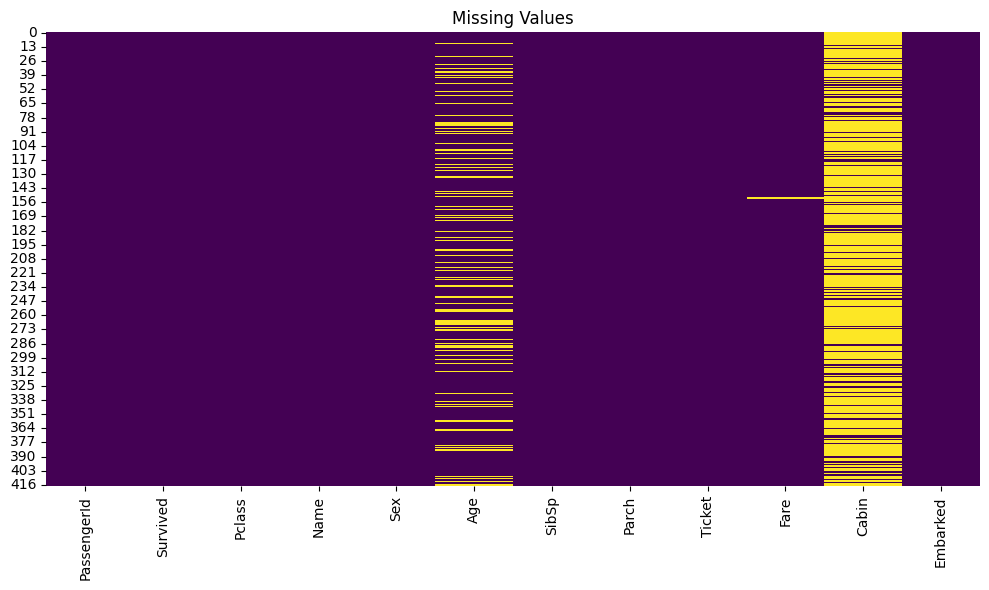

In [23]:

plt.figure(figsize=(10, 6))
sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values')
plt.tight_layout()
plt.savefig('missing_values.png')


## Basic Visualization for Survival by different features

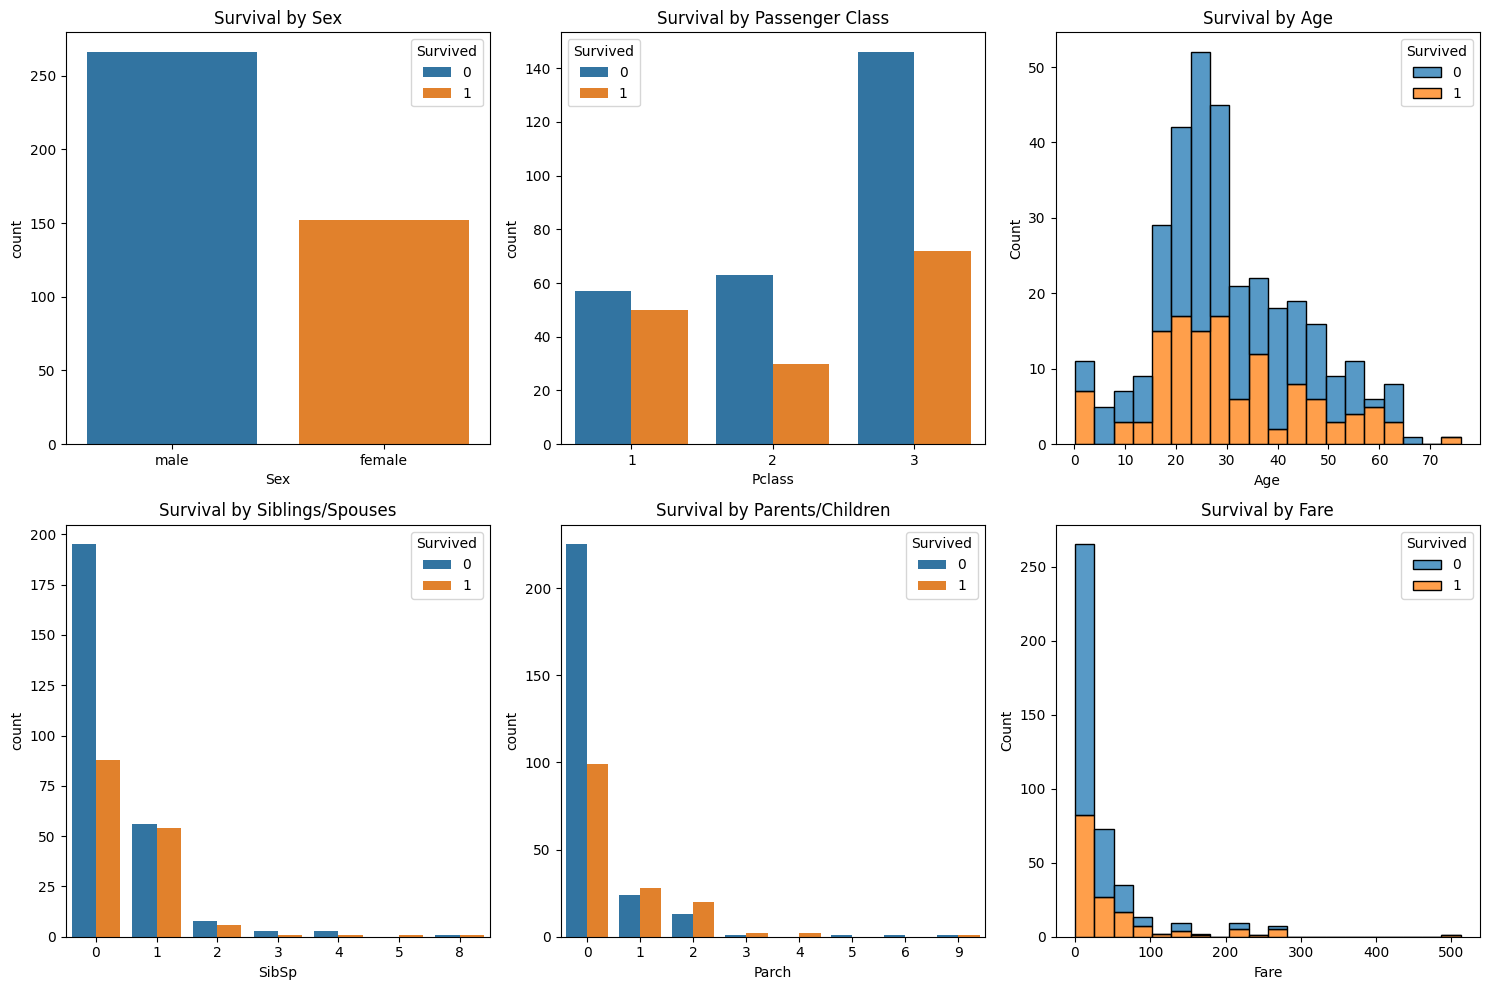

In [24]:

plt.figure(figsize=(15, 10))

# Survival by Sex
plt.subplot(2, 3, 1)
sns.countplot(x='Sex', hue='Survived', data=train_data)
plt.title('Survival by Sex')

# Survival by Pclass
plt.subplot(2, 3, 2)
sns.countplot(x='Pclass', hue='Survived', data=train_data)
plt.title('Survival by Passenger Class')

# Survival by Age
plt.subplot(2, 3, 3)
sns.histplot(x='Age', hue='Survived', data=train_data, bins=20, multiple='stack')
plt.title('Survival by Age')

# Survival by SibSp
plt.subplot(2, 3, 4)
sns.countplot(x='SibSp', hue='Survived', data=train_data)
plt.title('Survival by Siblings/Spouses')

# Survival by Parch
plt.subplot(2, 3, 5)
sns.countplot(x='Parch', hue='Survived', data=train_data)
plt.title('Survival by Parents/Children')

# Survival by Fare
plt.subplot(2, 3, 6)
sns.histplot(x='Fare', hue='Survived', data=train_data, bins=20, multiple='stack')
plt.title('Survival by Fare')

plt.tight_layout()
plt.savefig('survival_analysis.png')

## Feature Engineering

In [25]:

# Extract titles from names
train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Group rare titles
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
train_data['Title'] = train_data['Title'].replace(rare_titles, 'Rare')
train_data['Title'] = train_data['Title'].replace('Mlle', 'Miss')
train_data['Title'] = train_data['Title'].replace('Ms', 'Miss')
train_data['Title'] = train_data['Title'].replace('Mme', 'Mrs')

# Create family size feature
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1

# Create is_alone feature
train_data['IsAlone'] = (train_data['FamilySize'] == 1).astype(int)


train_data['HasCabin'] = (~train_data['Cabin'].isnull()).astype(int)


In [26]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone,HasCabin
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,1,1,0
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,2,0,0
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,1,1,0
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,1,1,0
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,3,0,0


## Prepare the Data Model

In [27]:

#Select features and target
X = train_data.drop(['Survived', 'Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)
y = train_data['Survived']

#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## DEfine numerical and categorical features

In [28]:

numerical_features = ['Age', 'Fare', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Title', 'IsAlone', 'HasCabin']

# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Create Model Pipeline

In [31]:

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Grid search for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 15],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare',
                                                                          'FamilySize']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Pclass',
                                                                          'Sex',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Title',
                                                                          'IsAlone',
                                                                          'HasCabin'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 10, 15],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='accuracy')

## Best model for Grid Search

In [32]:

best_model = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Make predictions
y_pred = best_model.predict(X_test)



Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best Cross-Validation Score: 1.0


## Evaluate the Model


Model Evaluation:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


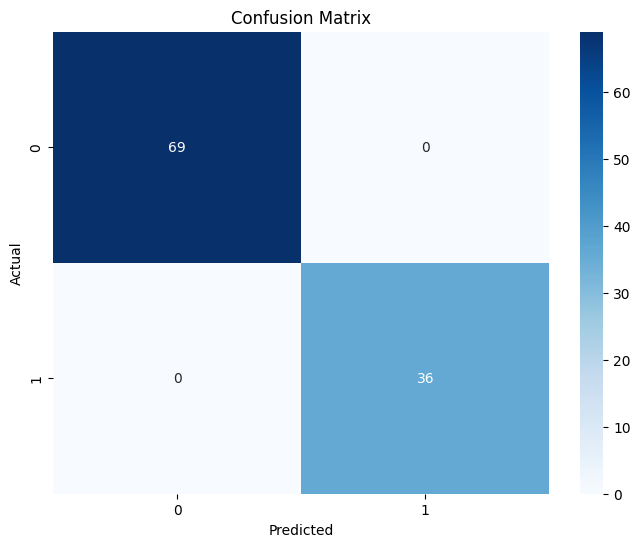

In [33]:

print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')

## Feature Importance and Save the model


Model saved as 'titanic_model.pkl'


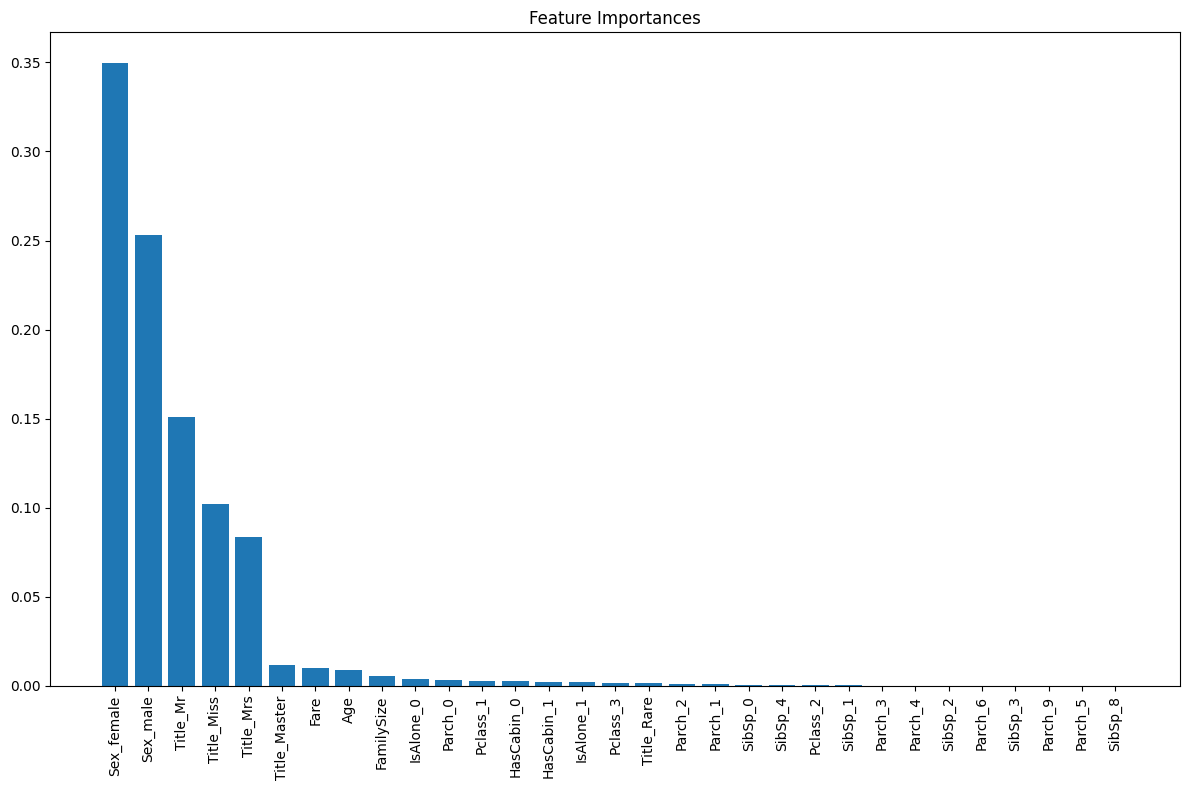

In [34]:

if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    # Get feature names after preprocessing
    ohe = best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
    cat_features = ohe.get_feature_names_out(categorical_features)
    feature_names = np.append(numerical_features, cat_features)

    # Get feature importances
    importances = best_model.named_steps['classifier'].feature_importances_


    indices = np.argsort(importances)[::-1]


    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances')
    plt.bar(range(len(indices)), importances[indices], align='center')
    plt.xticks(range(len(indices)), feature_names[indices], rotation=90)
    plt.tight_layout()
    plt.savefig('feature_importances.png')


import pickle
with open('titanic_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("\nModel saved as 'titanic_model.pkl'")

## Make prediction

In [35]:


import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load the saved model
with open('titanic_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)


new_data = pd.DataFrame({
    'Pclass': [3],
    'Sex': ['male'],
    'Age': [25],
    'SibSp': [0],
    'Parch': [0],
    'Fare': [7.25],
    'Title': ['Mr'],
    'FamilySize': [1],  # Make sure 'FamilySize' is present
    'IsAlone': [1],  # Make sure 'IsAlone' is present
    'HasCabin': [0]  # Make sure 'HasCabin' is present

})



prediction = loaded_model.predict(new_data)
print(f"Prediction: {prediction[0]}") # 0 for not survived, 1 for survived



Prediction: 0
